# DS-504: Feature Engineering Avanzado

**Objetivo**: Crear features compuestas que capturen patrones complejos de churn

**Input**: `data/processed/02_dataset_enriched_nyc.csv` (7,043 clientes × 30 columnas)

**Output**: `data/processed/04_dataset_engineered.csv` (7,043 clientes × ~45 columnas)

---

## 📋 Plan de Feature Engineering

Basado en insights de DS-503:

1. **Eliminación de Multicolinealidad** (VIF > 10)
   - `ChargesTotal` (VIF: 19.28) → Redundante con ChargesMonthly × Tenure
   - `Latitude/Longitude` (VIF: >180k) → Usar Borough en su lugar

2. **Features Compuestas** (Domain Knowledge)
   - Ratio de valor cliente
   - Índice de engagement
   - Conteo de servicios

3. **Binning Inteligente**
   - Tenure en grupos
   - Precio en segmentos

4. **Interacciones Clave**
   - Contrato × Tenure
   - Ingreso × Precio

5. **Transformaciones**
   - Log/Sqrt para reducir skewness

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Librerías importadas")

✓ Librerías importadas


## 1. Carga de Datos Enriquecidos

In [2]:
# Cargar dataset enriquecido de DS-502
df = pd.read_csv('../data/processed/02_dataset_enriched_nyc.csv')

print(f"📊 Dataset cargado: {df.shape[0]:,} clientes × {df.shape[1]} columnas\n")
print("Columnas disponibles:")
print(df.columns.tolist())

df.head(3)

📊 Dataset cargado: 7,043 clientes × 30 columnas

Columnas disponibles:
['CustomerID', 'City', 'State', 'Borough', 'ZipCode', 'Latitude', 'Longitude', 'MedianIncome', 'PopulationDensity', 'RegistrationDate', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'ChargesMonthly', 'ChargesTotal', 'Churn']


,CustomerID,City,State,Borough,ZipCode,Latitude,Longitude,MedianIncome,PopulationDensity,RegistrationDate,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,New York,NY,STATEN ISLAND,10310,40.645193,-74.108206,82200,8618,2023-11-30,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,No
1,0003-MKNFE,New York,NY,BRONX,10467,40.876717,-73.880262,40500,34920,2021-08-05,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,No
2,0004-TLHLJ,New York,NY,QUEENS,11105,40.771939,-73.909445,69300,21460,2021-11-25,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes


## 2. Eliminación de Variables Redundantes

### 2.1 Análisis VIF (DS-503)

Resultados previos:
- `ChargesTotal`: VIF = 19.28 (altamente colineal con ChargesMonthly)
- `Latitude`: VIF = 182,437 (redundante con Borough)
- `Longitude`: VIF = 182,438 (redundante con Borough)

**Estrategia**:
- Eliminar `ChargesTotal` del modelo ML
- Marcar `Latitude/Longitude` como features de visualización (no para ML)

In [3]:
# Crear copia para feature engineering
df_fe = df.copy()

# Guardar lat/lon para visualización (heatmaps) pero marcar para exclusión del modelo
visualization_features = ['Latitude', 'Longitude']

# Eliminar ChargesTotal (será reemplazado por features derivadas)
df_fe_model = df_fe.drop(columns=['ChargesTotal'], errors='ignore')

print("✓ Variables redundantes identificadas:")
print("  • ChargesTotal → Eliminada (VIF 19.28)")
print("  • Latitude/Longitude → Marcadas como solo-visualización (VIF >180k)")
print(f"\n📊 Shape después de limpieza: {df_fe_model.shape}")

✓ Variables redundantes identificadas:
  • ChargesTotal → Eliminada (VIF 19.28)
  • Latitude/Longitude → Marcadas como solo-visualización (VIF >180k)

📊 Shape después de limpieza: (7043, 29)


## 3. Features Compuestas (Domain Knowledge)

### 3.1 Customer Value Ratio

**Hipótesis**: Clientes que pagan mucho en relación a su ingreso tienen mayor riesgo de churn

In [4]:
# Customer Value Ratio = Gasto mensual / Ingreso mediano del área
# Valores altos = Cliente paga mucho vs ingreso de su zona
df_fe_model['CustomerValueRatio'] = df_fe_model['ChargesMonthly'] / (df_fe_model['MedianIncome'] / 12)

# Ratio como porcentaje del ingreso mensual
df_fe_model['PriceIncomePercent'] = (df_fe_model['ChargesMonthly'] / (df_fe_model['MedianIncome'] / 12)) * 100

print("✓ Customer Value Ratio creado")
print(f"\nDistribución del ratio (mediana: {df_fe_model['CustomerValueRatio'].median():.3f}):")
print(df_fe_model['CustomerValueRatio'].describe())

✓ Customer Value Ratio creado

Distribución del ratio (mediana: 0.012):
count    7043.000000
mean        0.012033
std         0.006854
min         0.002572
25%         0.006231
50%         0.011847
75%         0.015998
max         0.035141
Name: CustomerValueRatio, dtype: float64


### 3.2 Services Count & Engagement Score

**Hipótesis**: Clientes con más servicios contratados tienen menor churn (mayor lock-in)

In [5]:
# Lista de servicios binarios
service_columns = [
    'PhoneService',
    'MultipleLines',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

# Convertir servicios a binario (Yes=1, No/No phone service=0)
for col in service_columns:
    df_fe_model[f'{col}_Binary'] = df_fe_model[col].apply(lambda x: 1 if x == 'Yes' else 0)

# Conteo total de servicios
binary_service_cols = [f'{col}_Binary' for col in service_columns]
df_fe_model['ServicesCount'] = df_fe_model[binary_service_cols].sum(axis=1)

# Engagement Score = (Servicios × Tenure) / Precio
# Score alto = Cliente antiguo con muchos servicios y precio bajo (muy engaged)
df_fe_model['EngagementScore'] = (
    df_fe_model['ServicesCount'] * df_fe_model['Tenure']
) / (df_fe_model['ChargesMonthly'] + 1)  # +1 para evitar división por cero

print("✓ Services Count y Engagement Score creados")
print(f"\nServicios por cliente (promedio: {df_fe_model['ServicesCount'].mean():.1f}):")
print(df_fe_model['ServicesCount'].value_counts().sort_index())

✓ Services Count y Engagement Score creados

Servicios por cliente (promedio: 3.4):
ServicesCount
0      80
1    1701
2    1188
3     965
4     922
5     908
6     676
7     395
8     208
Name: count, dtype: int64


### 3.3 Lifetime Value Estimado

**Feature**: Valor que el cliente ha generado hasta ahora

In [6]:
# Estimación de valor total del cliente (ChargesMonthly × Tenure)
# Esto reemplaza ChargesTotal (que fue eliminado) pero con nombre más claro
df_fe_model['EstimatedLTV'] = df_fe_model['ChargesMonthly'] * df_fe_model['Tenure']

# LTV Promedio Mensual (para comparar clientes nuevos vs antiguos)
df_fe_model['AvgMonthlyValue'] = df_fe_model['EstimatedLTV'] / (df_fe_model['Tenure'] + 1)

print("✓ Lifetime Value features creados")
print(f"\nLTV promedio: ${df_fe_model['EstimatedLTV'].mean():,.2f}")

✓ Lifetime Value features creados

LTV promedio: $2,279.58


## 4. Binning Inteligente

### 4.1 Tenure Groups

In [7]:
# Grupos de tenure basados en análisis DS-503
def categorize_tenure(tenure):
    if tenure <= 12:
        return '0-12_months'
    elif tenure <= 24:
        return '12-24_months'
    elif tenure <= 48:
        return '24-48_months'
    else:
        return '48+_months'

df_fe_model['TenureGroup'] = df_fe_model['Tenure'].apply(categorize_tenure)

print("✓ Tenure Groups creados:")
print(df_fe_model['TenureGroup'].value_counts().sort_index())

✓ Tenure Groups creados:
TenureGroup
0-12_months     2186
12-24_months    1024
24-48_months    1594
48+_months      2239
Name: count, dtype: int64


### 4.2 Price Segments

In [8]:
# Segmentación de precio en cuartiles
df_fe_model['PriceSegment'] = pd.qcut(
    df_fe_model['ChargesMonthly'],
    q=4,
    labels=['Budget', 'Standard', 'Premium', 'Enterprise']
)

print("✓ Price Segments creados:")
print(df_fe_model.groupby('PriceSegment')['ChargesMonthly'].agg(['min', 'max', 'count']))

✓ Price Segments creados:
                min     max  count
PriceSegment                      
Budget        18.25   35.50   1762
Standard      35.55   70.35   1766
Premium       70.40   89.85   1757
Enterprise    89.90  118.75   1758


/var/folders/tl/td0sngws4s745yh_zfq6gt_w0000gn/T/ipykernel_62236/837077980.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_fe_model.groupby('PriceSegment')['ChargesMonthly'].agg(['min', 'max', 'count']))


## 5. Interacciones Clave

### 5.1 Contract × Tenure Interaction

In [9]:
# Alto riesgo: Contrato mensual + Cliente nuevo (< 6 meses)
df_fe_model['HighRisk_ContractTenure'] = (
    (df_fe_model['Contract'] == 'Month-to-month') &
    (df_fe_model['Tenure'] < 6)
).astype(int)

# Medio riesgo: Contrato mensual + Cliente mediano (6-12 meses)
df_fe_model['MediumRisk_ContractTenure'] = (
    (df_fe_model['Contract'] == 'Month-to-month') &
    (df_fe_model['Tenure'] >= 6) &
    (df_fe_model['Tenure'] < 12)
).astype(int)

print("✓ Contract × Tenure interactions creadas")
print(f"  • Alto Riesgo: {df_fe_model['HighRisk_ContractTenure'].sum():,} clientes")
print(f"  • Medio Riesgo: {df_fe_model['MediumRisk_ContractTenure'].sum():,} clientes")

✓ Contract × Tenure interactions creadas
  • Alto Riesgo: 1,318 clientes
  • Medio Riesgo: 590 clientes


### 5.2 Income × Price Mismatch

In [10]:
# Mismatch: Ingreso bajo (<$50k) pero precio alto (>$80/mes)
df_fe_model['IncomePriceMismatch'] = (
    (df_fe_model['MedianIncome'] < 50000) &
    (df_fe_model['ChargesMonthly'] > 80)
).astype(int)

print("✓ Income × Price Mismatch creada")
print(f"  • Clientes con mismatch: {df_fe_model['IncomePriceMismatch'].sum():,}")

✓ Income × Price Mismatch creada
  • Clientes con mismatch: 457


### 5.3 High Risk Segment (Geographic + Contract + Tenure)

In [11]:
# Segmento de máximo riesgo: Bronx + Month-to-month + Tenure < 12
df_fe_model['HighRiskSegment'] = (
    (df_fe_model['Borough'] == 'BRONX') &
    (df_fe_model['Contract'] == 'Month-to-month') &
    (df_fe_model['Tenure'] < 12)
).astype(int)

# Análisis de churn en este segmento
high_risk_churn = df_fe_model[df_fe_model['HighRiskSegment'] == 1]['Churn'].value_counts(normalize=True)

print("✓ High Risk Segment creado")
print(f"  • Tamaño del segmento: {df_fe_model['HighRiskSegment'].sum():,} clientes")
if 'Yes' in high_risk_churn:
    print(f"  • Churn rate en segmento: {high_risk_churn['Yes'] * 100:.1f}%")

✓ High Risk Segment creado
  • Tamaño del segmento: 434 clientes
  • Churn rate en segmento: 89.2%


## 6. Transformaciones (Reducción de Skewness)

### 6.1 Log Transformations

In [12]:
# Log de variables con distribución sesgada
df_fe_model['Log_ChargesMonthly'] = np.log1p(df_fe_model['ChargesMonthly'])  # log(1 + x)
df_fe_model['Log_EstimatedLTV'] = np.log1p(df_fe_model['EstimatedLTV'])
df_fe_model['Log_Tenure'] = np.log1p(df_fe_model['Tenure'])

print("✓ Log transformations aplicadas")

✓ Log transformations aplicadas


### 6.2 Square Root Transformations

In [13]:
# Sqrt para reducir outliers
df_fe_model['Sqrt_Tenure'] = np.sqrt(df_fe_model['Tenure'])
df_fe_model['Sqrt_ServicesCount'] = np.sqrt(df_fe_model['ServicesCount'])

print("✓ Square root transformations aplicadas")

✓ Square root transformations aplicadas


## 7. Visualización de Nuevas Features

### 7.1 Customer Value Ratio vs Churn

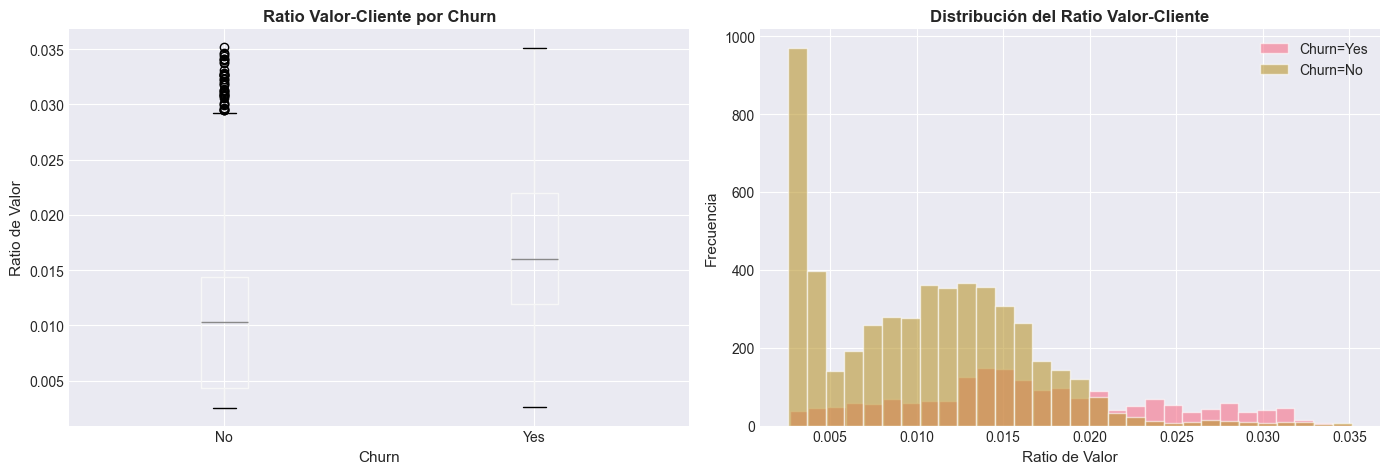

✓ Visualización guardada: 04_customer_value_ratio.png


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
df_fe_model.boxplot(column='CustomerValueRatio', by='Churn', ax=axes[0])
plt.suptitle("")  # Eliminar título automático
axes[0].set_title('Ratio Valor-Cliente por Churn', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=11)
axes[0].set_ylabel('Ratio de Valor', fontsize=11)

# Histogram
for churn_val in ['Yes', 'No']:
    data = df_fe_model[df_fe_model['Churn'] == churn_val]['CustomerValueRatio']
    axes[1].hist(data, alpha=0.6, label=f'Churn={churn_val}', bins=30)
axes[1].set_title('Distribución del Ratio Valor-Cliente', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Ratio de Valor', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/04_customer_value_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada: 04_customer_value_ratio.png")

### 7.2 Services Count vs Churn

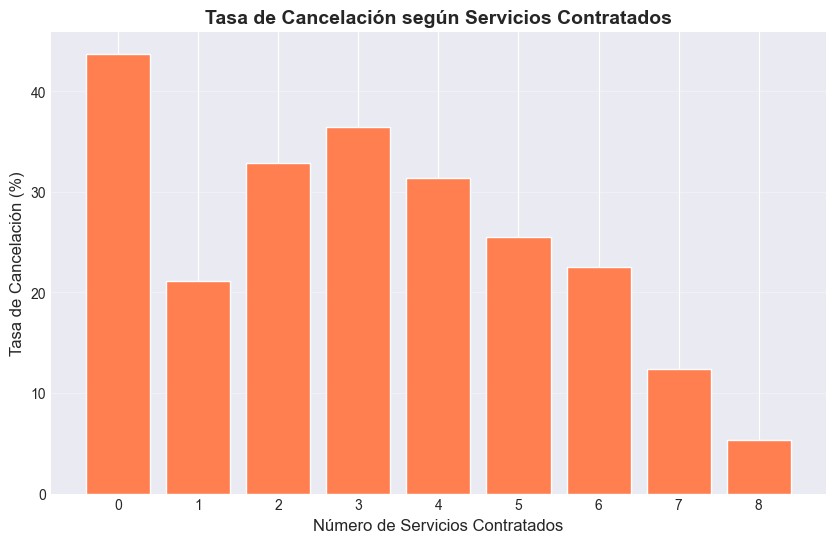

✓ Visualización guardada: 04_services_count_churn.png


In [15]:
# Churn rate por número de servicios
services_churn = df_fe_model.groupby('ServicesCount')['Churn'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
).reset_index()
services_churn.columns = ['ServicesCount', 'ChurnRate']

plt.figure(figsize=(10, 6))
plt.bar(services_churn['ServicesCount'], services_churn['ChurnRate'], color='coral')
plt.xlabel('Número de Servicios Contratados', fontsize=12)
plt.ylabel('Tasa de Cancelación (%)', fontsize=12)
plt.title('Tasa de Cancelación según Servicios Contratados', fontsize=14, fontweight='bold')
plt.xticks(range(0, 9))
plt.grid(axis='y', alpha=0.3)

plt.savefig('../reports/figures/04_services_count_churn.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada: 04_services_count_churn.png")

### 7.3 High Risk Segments

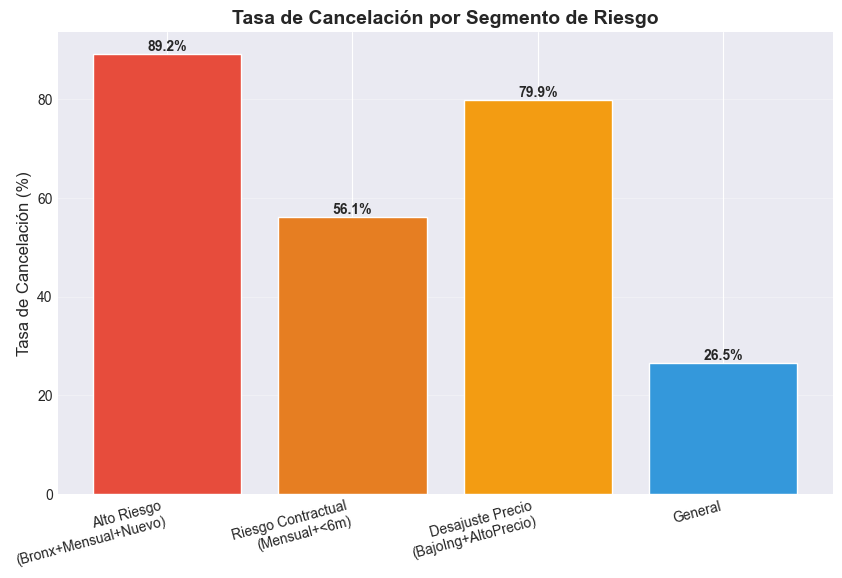

✓ Visualización guardada: 04_risk_segments_analysis.png


In [16]:
# Comparar churn rate en diferentes segmentos de riesgo
risk_segments = {
    'Alto Riesgo\n(Bronx+Mensual+Nuevo)': df_fe_model[df_fe_model['HighRiskSegment'] == 1],
    'Riesgo Contractual\n(Mensual+<6m)': df_fe_model[df_fe_model['HighRisk_ContractTenure'] == 1],
    'Desajuste Precio\n(BajoIng+AltoPrecio)': df_fe_model[df_fe_model['IncomePriceMismatch'] == 1],
    'General': df_fe_model
}

churn_rates = {}
for name, segment_df in risk_segments.items():
    if len(segment_df) > 0:
        churn_rate = (segment_df['Churn'] == 'Yes').sum() / len(segment_df) * 100
        churn_rates[name] = churn_rate

plt.figure(figsize=(10, 6))
bars = plt.bar(churn_rates.keys(), churn_rates.values(), color=['#e74c3c', '#e67e22', '#f39c12', '#3498db'])
plt.ylabel('Tasa de Cancelación (%)', fontsize=12)
plt.title('Tasa de Cancelación por Segmento de Riesgo', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig('../reports/figures/04_risk_segments_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada: 04_risk_segments_analysis.png")

## 8. Feature Importance Prelim (Correlaciones)

Análisis rápido de correlación de nuevas features con Churn

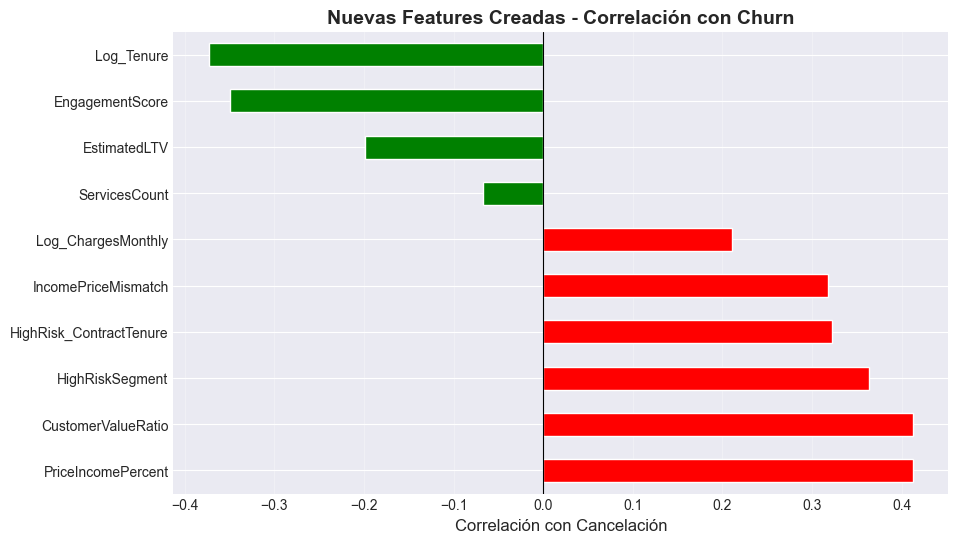


📊 Top 5 Nuevas Features más Correlacionadas con Churn:

PriceIncomePercent    0.412892
CustomerValueRatio    0.412892
Log_Tenure            0.373324
HighRiskSegment       0.363516
EngagementScore       0.349057
Name: Churn_Binary, dtype: float64


In [17]:
# Crear Churn_Binary para correlación
df_fe_model['Churn_Binary'] = (df_fe_model['Churn'] == 'Yes').astype(int)

# Nuevas features numéricas
new_features = [
    'CustomerValueRatio',
    'PriceIncomePercent',
    'ServicesCount',
    'EngagementScore',
    'EstimatedLTV',
    'HighRisk_ContractTenure',
    'IncomePriceMismatch',
    'HighRiskSegment',
    'Log_ChargesMonthly',
    'Log_Tenure'
]

# Calcular correlaciones
correlations = df_fe_model[new_features + ['Churn_Binary']].corr()['Churn_Binary'].drop('Churn_Binary').sort_values(ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color=['green' if x < 0 else 'red' for x in correlations])
plt.xlabel('Correlación con Cancelación', fontsize=12)
plt.title('Nuevas Features Creadas - Correlación con Churn', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

plt.savefig('../reports/figures/04_new_features_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 5 Nuevas Features más Correlacionadas con Churn:\n")
print(correlations.abs().sort_values(ascending=False).head(5))

## 9. Preparación Final del Dataset

### 9.1 Identificar Tipos de Features

In [18]:
# Categorizar features por tipo
metadata_features = ['CustomerID', 'RegistrationDate', 'City', 'State', 'ZipCode']
visualization_only_features = ['Latitude', 'Longitude']  # Solo para heatmaps
target = 'Churn'
binary_helper_features = ['Churn_Binary'] + binary_service_cols  # Features intermedias

# Features para modelo ML
all_features = df_fe_model.columns.tolist()
ml_features = [
    col for col in all_features
    if col not in metadata_features + visualization_only_features + [target] + binary_helper_features
]

print(f"📊 Inventario de Features:\n")
print(f"  • Metadata: {len(metadata_features)} features")
print(f"  • Visualización solamente: {len(visualization_only_features)} features")
print(f"  • Features para ML: {len(ml_features)} features")
print(f"  • Target: {target}")
print(f"\n  Total columnas en dataset: {len(all_features)}")

📊 Inventario de Features:

  • Metadata: 5 features
  • Visualización solamente: 2 features
  • Features para ML: 38 features
  • Target: Churn

  Total columnas en dataset: 55


### 9.2 Guardar Dataset Final

In [19]:
# Guardar dataset completo (incluye Lat/Lon para visualización)
output_path = '../data/processed/04_dataset_engineered.csv'
df_fe_model.to_csv(output_path, index=False)

print(f"✅ Dataset guardado: {output_path}")
print(f"   Shape: {df_fe_model.shape}")

# Guardar también lista de features para ML (metadata para DS-505)
import json

features_metadata = {
    'ml_features': ml_features,
    'visualization_only': visualization_only_features,
    'metadata': metadata_features,
    'target': target,
    'generated_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../data/processed/04_features_metadata.json', 'w') as f:
    json.dump(features_metadata, f, indent=2)

print("\n✅ Features metadata guardada: 04_features_metadata.json")

✅ Dataset guardado: ../data/processed/04_dataset_engineered.csv
   Shape: (7043, 55)

✅ Features metadata guardada: 04_features_metadata.json


## 10. Resumen Final

### ✅ DS-504 COMPLETADO

In [20]:
print("\n" + "=" * 80)
print("✅ DS-504 COMPLETADO - FEATURE ENGINEERING")
print("=" * 80)

print("\n🎯 FEATURES CREADAS:\n")

print("1️⃣ ELIMINACIÓN DE MULTICOLINEALIDAD:")
print("   • ChargesTotal eliminado (VIF 19.28)")
print("   • Latitude/Longitude excluidos de ML (VIF >180k, conservados para heatmaps)")

print("\n2️⃣ FEATURES COMPUESTAS (8 nuevas):")
print("   • CustomerValueRatio: Gasto vs Ingreso del área")
print("   • PriceIncomePercent: Precio como % del ingreso")
print("   • ServicesCount: Cantidad de servicios contratados")
print("   • EngagementScore: (Servicios × Tenure) / Precio")
print("   • EstimatedLTV: Valor de vida del cliente")
print("   • AvgMonthlyValue: LTV promedio mensual")

print("\n3️⃣ BINNING INTELIGENTE (2 nuevas):")
print("   • TenureGroup: 0-12, 12-24, 24-48, 48+ meses")
print("   • PriceSegment: Budget, Standard, Premium, Enterprise")

print("\n4️⃣ INTERACCIONES CLAVE (3 nuevas):")
print("   • HighRisk_ContractTenure: MTM + <6 meses")
print("   • MediumRisk_ContractTenure: MTM + 6-12 meses")
print("   • IncomePriceMismatch: Ingreso bajo + Precio alto")
print("   • HighRiskSegment: Bronx + MTM + <12 meses")

print("\n5️⃣ TRANSFORMACIONES (5 nuevas):")
print("   • Log_ChargesMonthly, Log_EstimatedLTV, Log_Tenure")
print("   • Sqrt_Tenure, Sqrt_ServicesCount")

print("\n📊 ESTADÍSTICAS DEL DATASET:\n")
print(f"   • Clientes: {df_fe_model.shape[0]:,}")
print(f"   • Features totales: {df_fe_model.shape[1]}")
print(f"   • Features para ML: {len(ml_features)}")
print(f"   • Churn rate: {(df_fe_model['Churn'] == 'Yes').sum() / len(df_fe_model) * 100:.2f}%")

print("\n📁 Archivos generados:\n")
print("   1. data/processed/04_dataset_engineered.csv")
print("   2. data/processed/04_features_metadata.json")
print("   3. reports/figures/04_customer_value_ratio.png")
print("   4. reports/figures/04_services_count_churn.png")
print("   5. reports/figures/04_risk_segments_analysis.png")
print("   6. reports/figures/04_new_features_correlation.png")

print("\n🎫 Próximo ticket:\n")
print("   DS-505: Entrenamiento de Modelos Candidatos")
print("")
print("   Modelos a entrenar:")
print("   • Logistic Regression (Baseline interpretable)")
print("   • Random Forest (Robusto, feature importance)")
print("   • XGBoost (Champion candidato, AUC >0.85)")
print("   • LightGBM (Alternativa rápida)")
print("")
print("   Estrategia de validación:")
print("   • Train/Validation/Test: 70/15/15")
print("   • Stratified K-Fold (k=5)")
print("   • Hyperparameter tuning con GridSearchCV")
print("")
print("=" * 80)
print("✅ DS-504 Feature Engineering completado exitosamente")
print("=" * 80)


✅ DS-504 COMPLETADO - FEATURE ENGINEERING

🎯 FEATURES CREADAS:

1️⃣ ELIMINACIÓN DE MULTICOLINEALIDAD:
   • ChargesTotal eliminado (VIF 19.28)
   • Latitude/Longitude excluidos de ML (VIF >180k, conservados para heatmaps)

2️⃣ FEATURES COMPUESTAS (8 nuevas):
   • CustomerValueRatio: Gasto vs Ingreso del área
   • PriceIncomePercent: Precio como % del ingreso
   • ServicesCount: Cantidad de servicios contratados
   • EngagementScore: (Servicios × Tenure) / Precio
   • EstimatedLTV: Valor de vida del cliente
   • AvgMonthlyValue: LTV promedio mensual

3️⃣ BINNING INTELIGENTE (2 nuevas):
   • TenureGroup: 0-12, 12-24, 24-48, 48+ meses
   • PriceSegment: Budget, Standard, Premium, Enterprise

4️⃣ INTERACCIONES CLAVE (3 nuevas):
   • HighRisk_ContractTenure: MTM + <6 meses
   • MediumRisk_ContractTenure: MTM + 6-12 meses
   • IncomePriceMismatch: Ingreso bajo + Precio alto
   • HighRiskSegment: Bronx + MTM + <12 meses

5️⃣ TRANSFORMACIONES (5 nuevas):
   • Log_ChargesMonthly, Log_EstimatedL